# Modeling
1. Split the full dataset into train, test, and validation sets. 
2. Test out several of the machine learning methods you learned. 
3. Evaluate the accuracy of the various models, tuning parameters as necessary.
4. Determine the winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, using F1 score is suggested as the metric to optimize.

As suggested in sklearn cheat map, the following models will be tested:

- LinearSVC
- Gradient-boosted tree classifier

<img src="./img_src/ml_map.png">

# 1. Data pre-processing

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf,col,mean,count,when,isnan,isnull
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import to_date,datediff,date_sub
from pyspark.sql.types import IntegerType,TimestampType,DateType

from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer
from pyspark.ml.classification import LinearSVC,GBTClassifier 
from pyspark.ml.classification import LinearSVCModel, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# create Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify_Modeling") \
        .getOrCreate()

In [3]:
# import data
data_path = "./data/user_mat.json/"
df = spark.read.json(data_path)
df.persist()

DataFrame[Add Friend: bigint, Add to Playlist: bigint, Churn: bigint, Error: bigint, Roll Advert: bigint, Thumbs Down: bigint, Thumbs Up: bigint, active_days: bigint, avg_duration_recent: double, delta Add Friend: bigint, delta Add to Playlist: bigint, delta Error: bigint, delta Roll Advert: bigint, delta Thumbs Down: bigint, delta Thumbs Up: bigint, delta_avg_duration: double, delta_avg_nb_item: double, gender_flag: bigint, hasDowngraded: bigint, hasUpgraded: bigint, level: bigint, most_resent: string, registration_date: string, tenure: bigint, userId: string]

In [4]:
df.count()

225

In [5]:
df = df.drop("userId","registration_date","most_resent").fillna(0)
df.printSchema()

root
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Churn: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- active_days: long (nullable = true)
 |-- avg_duration_recent: double (nullable = false)
 |-- delta Add Friend: long (nullable = true)
 |-- delta Add to Playlist: long (nullable = true)
 |-- delta Error: long (nullable = true)
 |-- delta Roll Advert: long (nullable = true)
 |-- delta Thumbs Down: long (nullable = true)
 |-- delta Thumbs Up: long (nullable = true)
 |-- delta_avg_duration: double (nullable = false)
 |-- delta_avg_nb_item: double (nullable = false)
 |-- gender_flag: long (nullable = true)
 |-- hasDowngraded: long (nullable = true)
 |-- hasUpgraded: long (nullable = true)
 |-- level: long (nullable = true)
 |-- tenure: long (nullable = true)



## 1.1 Check data distribution

In [6]:
# get feature names
feature_names = df.drop("Churn").columns
feature_nb = len(feature_names)


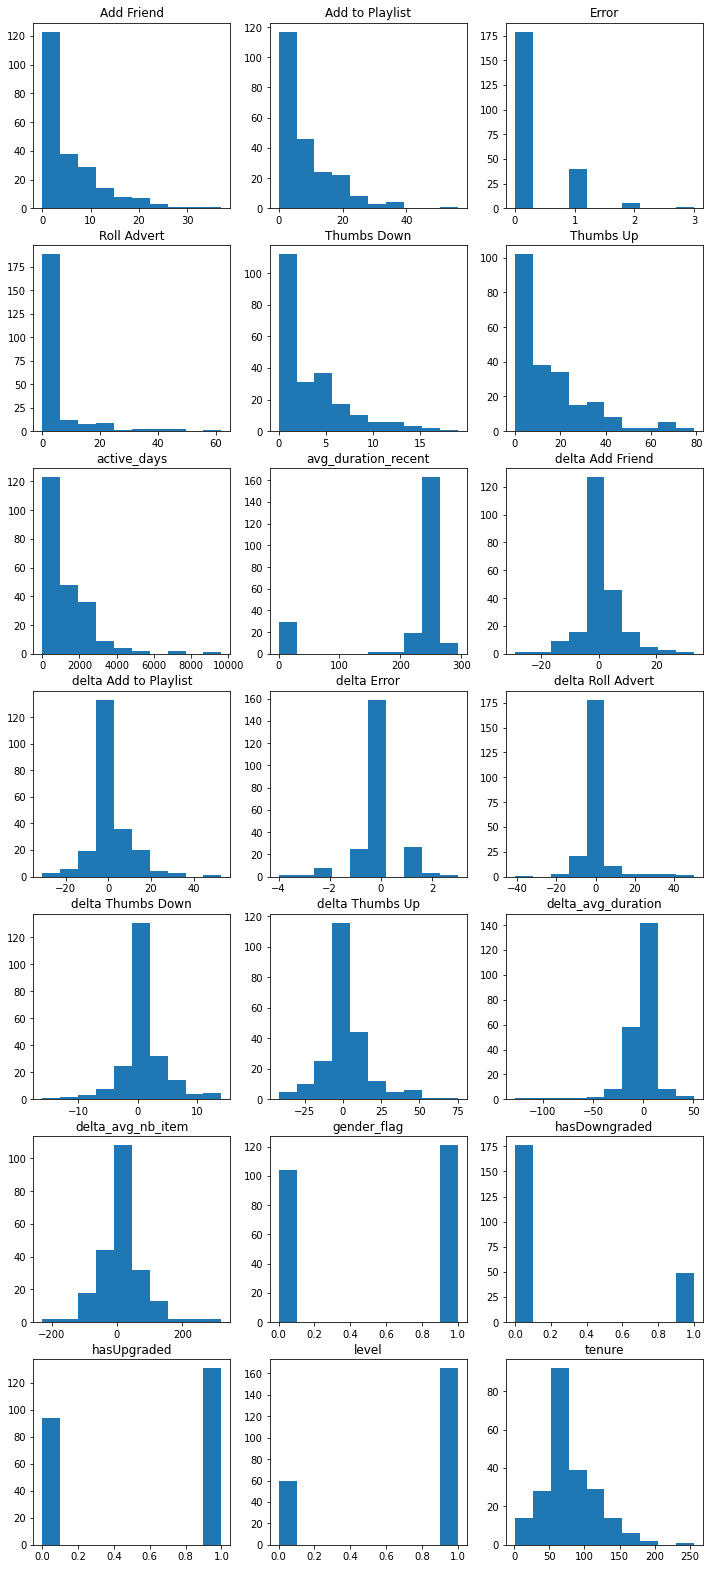

In [7]:
# plot the distribution of each feature
n_per_row = 3
n_rows = int(feature_nb/n_per_row)

def get_fig_position(i,n_per_row):
    row = i/n_per_row
    col = i%n_per_row
    return int(row),int(col)

# plot hist
fig,ax = plt.subplots(n_rows,n_per_row,figsize=[12,28])
for i,name in enumerate(feature_names):
    ix,iy = get_fig_position(i,n_per_row)
    axes = ax[ix][iy]
    feature = df.select(name).toPandas()
    axes.set_title(name)
    axes.hist(feature)
plt.show()

## 1.2 Split dataset

In [8]:
# assemvle features into a vector
assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
df_vec = assembler.transform(df)
df_vec = df_vec.select("features","Churn")
df_vec.show()

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|[1.0,0.0,0.0,1.0,...|    0|
|[8.0,6.0,1.0,2.0,...|    0|
|(21,[0,1,3,4,5,6,...|    1|
|(21,[6,19,20],[21...|    0|
|(21,[6,7,20],[78....|    1|
|[5.0,7.0,1.0,16.0...|    0|
|[1.0,1.0,0.0,10.0...|    1|
|(21,[6,20],[44.0,...|    1|
|(21,[1,3,5,6,7,8,...|    1|
|(21,[0,1,3,4,5,6,...|    0|
|[7.0,10.0,0.0,21....|    1|
|[0.0,3.0,0.0,19.0...|    0|
|(21,[6,16,20],[23...|    1|
|[1.0,11.0,0.0,21....|    1|
|[7.0,9.0,0.0,5.0,...|    1|
|(21,[6,7,16,19,20...|    1|
|(21,[6,17,18,19,2...|    1|
|[1.0,0.0,0.0,4.0,...|    0|
|(21,[6,16,20],[75...|    1|
|[4.0,10.0,0.0,39....|    0|
+--------------------+-----+
only showing top 20 rows



In [9]:
# split dataset 
train, test  = df_vec.randomSplit([0.85,0.15],seed=1234)

## 1.3 Scaling

In [10]:
# scaling data
from pyspark.ml.feature import Normalizer

scaler = Normalizer(inputCol="features",outputCol="scaledFeatures")

# 2. Modeling

## 2.1 classifier model & parameter

In [11]:
svc = LinearSVC(featuresCol="features",labelCol="Churn")

svc_grid = ParamGridBuilder()\
            .addGrid(svc.regParam,[0, 0.1, 0.01])\
            .build()

In [12]:
gbt = GBTClassifier(featuresCol="features",labelCol="Churn")

gbt_grid = ParamGridBuilder()\
            .addGrid(gbt.maxDepth,[5,10])\
            .addGrid(gbt.stepSize,[0.1,0.01])\
            .build()

## 2.2 Pipeline

In [13]:
def build_pipeline(scaler,clf):
    pipeline = Pipeline(stages=[scaler,clf])
    return pipeline

## 2.3 Cross Validation

In [14]:
def build_cv(pipeline,paramGrid,evaluator,n_folder=3):
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=n_folder
    )
    return cv

## 2.4 Model training

In [15]:
# evaluator
bi_evaluator = BinaryClassificationEvaluator(labelCol="Churn")

In [16]:
# model1 : SVC
svc_pipe  = build_pipeline(scaler,svc)
svc_cv    = build_cv(svc_pipe,svc_grid,bi_evaluator)
svc_model = svc_cv.fit(train)
svc_pred  = svc_model.transform(test)

In [17]:
# model2: GBT
gbt_pipe  = build_pipeline(scaler,gbt)
gbt_cv    = build_cv(gbt_pipe,gbt_grid,bi_evaluator)
gbt_model = gbt_cv.fit(train)
gbt_pred  = gbt_model.transform(test)

# 3. Evaluation

In [79]:
def model_summary_report(model):
    """
    Used on classifier model to print report (not able to use for CrossValidator)
    """
    summary = model.summary()
    
    # one value
    accuracy = summary.accuracy

    # value for each label
    labels   = summary.labels
    recall   = summary.recallByLabel
    precision= summary.precisionByLabel
    Fscore   = summary.fMeasureByLabel()

    print("Report on validation set")
    print("-"*20)
    print("Accuracy: %.4f"%accuracy)
    print("\n")
    print(f"label:\t\t{int(labels[0])}\t\t{int(labels[1])}")
    print(f"Recall\t\t{recall[0]:.4f}\t\t{recall[1]:.4f}")
    print(f"Precision\t{precision[0]:.4f}\t\t{precision[1]:.4f}")
    print(f"F-score\t\t{Fscore[0]:.4f}\t\t{Fscore[1]:.4f}")

In [47]:
def model_evaluation_report(model, pred):
    """
    Give report on testset
    
    INPUT
    @model : trained model
    @pred  : model prediction 
    """
    # BinaryClassificationEvaluator
    # docs : https://spark.apache.org/docs/latest/api/java/index.html?org/apache/spark/ml/evaluation/BinaryClassificationEvaluator.html
    # - posiblematric MatricName = {"areaUnderROC" (default), "areaUnderPR"}
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Churn")
    metrics = ["f1", "accuracy", "weightedRecall","weightedPrecision" ]
    
    evaluation = dict()
    for matric in metrics:
        evaluator.setMetricName(matric)
        eval_val = evaluator.evaluate(pred)
        evaluation[matric] = eval_val
    
    print("Report on testset")
    print("-"*20)
    for matric,value in evaluation.items():
        print(matric + ": " + "%.4f"%value)


In [86]:
print("LinearSVC")
model_evaluation_report(svc_model,svc_pred)

LinearSVC
Report on testset
--------------------
f1: 0.8107
accuracy: 0.8182
weightedRecall: 0.8182
weightedPrecision: 0.8074


In [84]:
print("Gradient-boosted tree classifier")
model_evaluation_report(gbt_model,gbt_pred)

Gradient-boosted tree classifier
Report on testset
--------------------
f1: 0.7224
accuracy: 0.7045
weightedRecall: 0.7045
weightedPrecision: 0.7571


# 4. Save model

In [18]:
# Save model
model = svc_model.bestModel
model.save("./model/svc.pkl")

In [19]:
# Load model
model = PipelineModel.load("./model/svc.pkl")